# In this Notebook...
- Functions to evaluate end yard layout

# Imports

In [23]:
import pandas as pd
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Needed Functions

In [24]:
#Checks if current position is not floating.
def CheckBelow(Environment, X, Y, Z):
    return Z == 0 or (Environment[X,Y,:Z] != '0').all()

#Checks if current position has container.
def CheckPos(Environment, Size, X, Y, Z):
    if not ExceedsLot(Size, X, Y, Z):
        return Environment[X, Y, Z] != '0'
    else:
        return False

#Checks if coordinates exceed lot.
def ExceedsLot(Size, X, Y, Z):
    return Size[2] <= Z or Size[1] <= Y or Size[0] <= X or Z < 0 or Y < 0 or X < 0

#Check whether container is in the middle of other containers.
def CheckMiddle(Environment, Size, X, Y, Z):
    return CheckPos(Environment, Size, X, Y - 1, 0) and CheckPos(Environment, Size, X, Y + 1, 0)

#Adds container to environment using state.
def AddContainer(Environment, Size, State, X, Y, Z):
    tempEnvironment = np.copy(Environment)
    if CheckBelow(Environment, X, Y, Z) and not CheckPos(Environment, Size, X, Y, Z) and not ExceedsLot(Size, X, Y, Z) and not CheckMiddle(Environment, Size, X, Y, Z):
        tempEnvironment[X,Y,Z] = State
    return tempEnvironment

In [25]:
def generateEnvironment(size=[3,3,2]):
    c =  [[['0'] * size[2]] * size[1]] * size[0]
    cSize = size[0]*size[1]*size[2]*3
    actionSize = size[0]*size[1]*size[2]
    speelveld = np.array(c)
    return speelveld, size

# Convert Functions

In [26]:
#From X,Y,Z coördinates to index in array
def coord_to_ind(X, Y, Z, lot_size):
    grid = np.arange(np.prod(lot_size)).reshape(lot_size)
    ind = grid[X][Y][Z]
    return ind

#From index in array to X,Y,Z coördinates
def ind_to_coord(ind, lot_size):
    grid = np.arange(np.prod(lot_size)).reshape(lot_size)
    coord = np.where(grid[:,:,:] == ind)
    X = coord[0][0]
    Y = coord[1][0]
    Z = coord[2][0]
    return X, Y, Z

# Routes Function

In [27]:
#returns from a container in a yard layout, the two routes to get that container
def cont_routes(lot_indeling, lot_size, ind): #lot_indeling: array, lot_size: [x,y,z], ind: int
    X = lot_size[0]
    Y = lot_size[1]
    Z = lot_size[2]
    lot_index = np.arange(np.prod(lot_size)).reshape(lot_size) #array with all the indices
    indc = ind_to_coord(ind, lot_size) #find coordinates of given index
    
    #add container stack of given container as start of route
    stackvalue = lot_indeling[indc[0]][indc[1]]
    stackkey = lot_index[indc[0]][indc[1]]
    stackdict = dict(zip(stackkey,stackvalue))
    
    #calculate route 1
    routestart = {k: v for k, v in stackdict.items() if k >= ind}
    route1 = routestart
    i = 0
    while (lot_index[indc[0]][indc[1]-i][0] % (Y*Z)) > 0:
        for z in range(Z):
            route1[lot_index[indc[0]][indc[1]-(i+1)][z]] = lot_indeling[indc[0]][indc[1]-(i+1)][z]
        i += 1
    
    #calculate route 2
    routestart = {k: v for k, v in stackdict.items() if k >= ind}
    route2 = routestart
    i = 0
    while (lot_index[indc[0]][indc[1]+i][Z-1] % (Y*Z)) < (Y*Z-1):
        for z in range(Z):
            route2[lot_index[indc[0]][indc[1]+(i+1)][z]] = lot_indeling[indc[0]][indc[1]+(i+1)][z]
        i += 1
    
    return route1, route2 #route1: dictionary, route2: dictionary

# Score/Inbox Function

In [28]:
#Returns the score and the amount of boxed in containers in a layout
#WARNING: The function works best when layout is full
def score_eindveld(lot_indeling,lot_size):
    X = lot_size[0]
    Y = lot_size[1]
    Z = lot_size[2]
    lot_index = np.arange(np.prod(lot_size)).reshape(lot_size)
    
    #make a list of all unique prio in the layout
    #'0' is an open space so it doesn't count
    #highest value (lowest prio) doesn't count
    if np.unique(lot_indeling)[0] == '0':
        lot_unique = np.unique(lot_indeling)[1:-1]
    else:
        lot_unique = np.unique(lot_indeling)[:-1]

    score = 0
    inbox = 0
    for p in lot_unique:
    
        for i in range(len(np.where(lot_indeling == p)[0])):
            obstaclesdict = {}
            
            x = np.where(lot_indeling == p)[0][i]
            y = np.where(lot_indeling == p)[1][i]
            z = np.where(lot_indeling == p)[2][i]
            routes = cont_routes(lot_indeling, lot_size, lot_index[x][y][z])
            routelen1 = len({k: v for k,v in routes[0].items() if int(v) > int(p)})
            routelen2 = len({k: v for k,v in routes[1].items() if int(v) > int(p)})

            #choose first route if shorter than second
            if routelen1 < routelen2:
                shortroute = routes[0]
            #choose second route if shorter than first
            elif routelen1 > routelen2:
                shortroute = routes[1]
            #if both routes equally long, look how many containers of same prio are on each route
            else:
                sameclassroute1 = sum(1 for v in routes[0].values() if v <= list(routes[0].values())[0])
                sameclassroute2 = sum(1 for v in routes[1].values() if v <= list(routes[1].values())[0])
                #choose first route if amount of same prio equal or more than second
                if sameclassroute1 >= sameclassroute2:
                    shortroute = routes[0]
                #choose second route if amount of prio more than first
                else:
                    shortroute = routes[1]

            print('beste route: {0}'.format(shortroute))
            
            #save all containers that are in the way (containers with higher value)
            for c in shortroute:
                if int(shortroute[c]) > int(p):
                    obstaclesdict[c] = shortroute[c]
            
            #decrease score when containers are in the way
            #this also means the container is boxed in
            if len(obstaclesdict) > 0:
                inbox += 1
                print('blocked in?: YES')
                for o in obstaclesdict:
                    score = score - (int(obstaclesdict[o]) - int(p)) 
                    
            #increase score when no containers in the way
            else:
                print('blocked in?: NO')
                score += ((Y*Z)/2) 
                
            print('-----------------')
    
    return score, inbox #score: integer, inbox: integer

# Testing on Environment

In [29]:
#Create yard where you can test functions
lotsize = [3,3,2]
def vulenv(lot, index, prio):
    act_loc = ind_to_coord(index, lotsize)
    new_lot = AddContainer(lot, lotsize, prio, act_loc[0], act_loc[1], act_loc[2])
    return new_lot

lot = generateEnvironment(lotsize)[0]
lot = vulenv(lot, 0, 1)
lot = vulenv(lot, 1, 2)
lot = vulenv(lot, 2, 2)
lot = vulenv(lot, 3, 2)
lot = vulenv(lot, 4, 1)
lot = vulenv(lot, 5, 3)
lot = vulenv(lot, 6, 1)
lot = vulenv(lot, 7, 3)
lot = vulenv(lot, 8, 2)
lot = vulenv(lot, 9, 2)
lot = vulenv(lot, 10, 1)
lot = vulenv(lot, 11, 3)
lot = vulenv(lot, 12, 1)
lot = vulenv(lot, 13, 3)
lot = vulenv(lot, 14, 2)
lot = vulenv(lot, 15, 2)
lot = vulenv(lot, 16, 1)
lot = vulenv(lot, 17, 3)
print(lot)

[[['1' '2']
  ['2' '2']
  ['1' '3']]

 [['1' '3']
  ['2' '2']
  ['1' '3']]

 [['1' '3']
  ['2' '2']
  ['1' '3']]]


In [30]:
idc = 0
rs = cont_routes(lot, lotsize,idc)
#print('container: {0}, routes: {1}'.format(idc, rs))
#print('-----------------')
r1 = rs[0]
r2 = rs[1]
print('score: {0}, aantal ingeboxt: {1}'.format(score_eindveld(lot,lotsize)[0],score_eindveld(lot,lotsize)[1]))

beste route: {0: '1', 1: '2'}
blocked in?: YES
-----------------
beste route: {4: '1', 5: '3'}
blocked in?: YES
-----------------
beste route: {6: '1', 7: '3'}
blocked in?: YES
-----------------
beste route: {10: '1', 11: '3'}
blocked in?: YES
-----------------
beste route: {12: '1', 13: '3'}
blocked in?: YES
-----------------
beste route: {16: '1', 17: '3'}
blocked in?: YES
-----------------
beste route: {1: '2'}
blocked in?: NO
-----------------
beste route: {2: '2', 3: '2', 0: '1', 1: '2'}
blocked in?: NO
-----------------
beste route: {3: '2', 0: '1', 1: '2'}
blocked in?: NO
-----------------
beste route: {8: '2', 9: '2', 6: '1', 7: '3'}
blocked in?: YES
-----------------
beste route: {9: '2', 6: '1', 7: '3'}
blocked in?: YES
-----------------
beste route: {14: '2', 15: '2', 12: '1', 13: '3'}
blocked in?: YES
-----------------
beste route: {15: '2', 12: '1', 13: '3'}
blocked in?: YES
-----------------
beste route: {0: '1', 1: '2'}
blocked in?: YES
-----------------
beste route: {4:

In [33]:
#import model results that used this function
DQNresults = pd.read_csv("DQNvsRandom_results.csv")
print(DQNresults)
print(DQNresults.iloc[0].mean())
print(DQNresults.iloc[1].mean())

    0   1   2   3   4   5   6   7   8   9  10  11  12
0  18  14  19  12  11   7  18  13   9  14  17   9  13
1  37  46  39  43  43  39  37  32  39  42  46  45  35
13.384615384615385
40.23076923076923


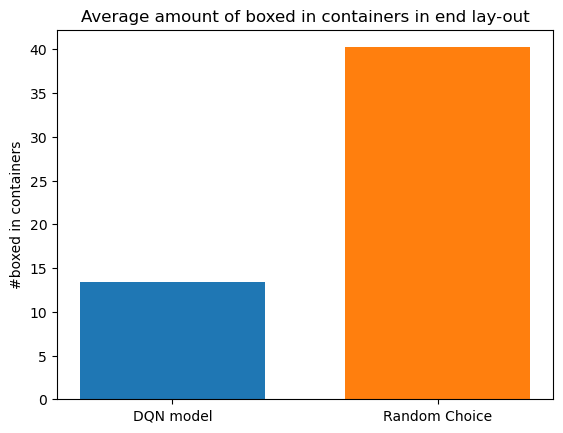

In [31]:
#plot results
x = ["DQN model","Random Choice"]
y = [np.array(DQNresults.iloc[0]).mean(), np.array(DQNresults.iloc[1]).mean()]
c = ['#1f77b4','#ff7f0e']

plt.title('Average amount of boxed in containers in end lay-out')
plt.ylabel('#boxed in containers')
plt.bar(x,y,width=0.7, color = c)
plt.savefig('DQNvsRandom.png',dpi=300)
plt.show()